# INSTITUTO TECNOLÓGICO Y DE ESTUDIOS SUPERIORES DE MONTERREY
Avance 2. Ingeniería de características

Sistema de visión computacional para conteo e identificación de cajas en pallets

Proyecto Integrador (Gpo 10) Equipo #37 - Almacenes

Profesores Titulares:
Dra. Grettel Barceló Alonso
Dr. Luis Falcón
Dra. Maria de la Paz Rico
Dr. Jesús Camacho González

Integrantes:

Alan Camerino Cortés Cruz A01167072

Josué Daniel Lescano López A01367234

Ariel Mora Monroy A01795561

Domingo 15 Febrero 2026



# El Avance # 2 y 3 Se encuentra posteriormente. Por favor deslizar hacia abajo

# Avance 1.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

video_path = "/content/drive/MyDrive/Proyecto Integrador Equipo37/Video Segmentation/Video Segmentation.mp4"
base_dir   = "/content/drive/MyDrive/Proyecto Integrador Equipo37/Video Segmentation"

Mounted at /content/drive


In [2]:
import os

raw_dir     = os.path.join(base_dir, "data/raw_frames")
sampled_dir = os.path.join(base_dir, "data/sampled_frames")

os.makedirs(raw_dir, exist_ok=True)
os.makedirs(sampled_dir, exist_ok=True)

In [3]:
import cv2
import os
import math

cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration_sec = total_frames / fps

print("FPS:", fps)
print("Total frames:", total_frames)
print("Duración (s):", duration_sec)

# Extraer 1 frame por segundo
step = int(round(fps * 1))  # 1 segundo

frame_idx = 0
saved = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    if frame_idx % step == 0:
        out_path = os.path.join(sampled_dir, f"frame_{frame_idx:06d}.jpg")
        cv2.imwrite(out_path, frame)
        saved += 1

    frame_idx += 1

cap.release()
print("Frames guardados:", saved)

FPS: 30.0
Total frames: 764
Duración (s): 25.466666666666665
Frames guardados: 26


In [4]:
import pandas as pd
import glob

files = sorted(glob.glob(os.path.join(sampled_dir, "*.jpg")))

rows = []
for f in files:
    rows.append({"filename": os.path.basename(f), "path": f})

df = pd.DataFrame(rows)
csv_path = os.path.join(base_dir, "data/eda/frames_index.csv")
os.makedirs(os.path.dirname(csv_path), exist_ok=True)
df.to_csv(csv_path, index=False)

print("CSV guardado en:", csv_path)
df.head()

CSV guardado en: /content/drive/MyDrive/Proyecto Integrador Equipo37/Video Segmentation/data/eda/frames_index.csv


filename                                               path
0  frame_000000.jpg  /content/drive/MyDrive/Proyecto Integrador Equ...
1  frame_000030.jpg  /content/drive/MyDrive/Proyecto Integrador Equ...
2  frame_000060.jpg  /content/drive/MyDrive/Proyecto Integrador Equ...
3  frame_000090.jpg  /content/drive/MyDrive/Proyecto Integrador Equ...
4  frame_000120.jpg  /content/drive/MyDrive/Proyecto Integrador Equ...

In [5]:
import numpy as np
import pandas as pd
import cv2
import glob, os

# Lista de imágenes
files = sorted(glob.glob(os.path.join(sampled_dir, "*.jpg")))

# Índice con rutas (df)
df = pd.DataFrame({
    "filename": [os.path.basename(f) for f in files],
    "path": files
})

# Calculamos métricas y construir stats
def image_stats(img_bgr):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    brightness = float(np.mean(gray))
    blur = float(cv2.Laplacian(gray, cv2.CV_64F).var())
    return brightness, blur

stats = []
for f in files:
    img = cv2.imread(f)
    if img is None:
        continue  # por si alguna imagen está corrupta
    b, bl = image_stats(img)
    stats.append({
        "filename": os.path.basename(f),
        "brightness": b,
        "blur": bl
    })

# df_stats
df_stats = pd.DataFrame(stats)

# 5) Merge para agregar path
df_stats = df_stats.merge(df[["filename", "path"]], on="filename", how="left")

print("df_stats listo. Columnas:", df_stats.columns.tolist())
print("Paths nulos:", df_stats["path"].isna().sum())
df_stats.head()

df_stats listo. Columnas: ['filename', 'brightness', 'blur', 'path']
Paths nulos: 0


filename  brightness        blur  \
0  frame_000000.jpg   97.924965  141.190448   
1  frame_000030.jpg   96.214860  163.124427   
2  frame_000060.jpg   95.633990  200.598275   
3  frame_000090.jpg   95.607826  193.733635   
4  frame_000120.jpg   95.735885  124.898713   

                                                path  
0  /content/drive/MyDrive/Proyecto Integrador Equ...  
1  /content/drive/MyDrive/Proyecto Integrador Equ...  
2  /content/drive/MyDrive/Proyecto Integrador Equ...  
3  /content/drive/MyDrive/Proyecto Integrador Equ...  
4  /content/drive/MyDrive/Proyecto Integrador Equ...

# Avance 1. Análisis Univariante

In [6]:
import numpy as np
import pandas as pd
import cv2
import os

def image_stats(img_bgr):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    brightness = float(np.mean(gray))
    blur = float(cv2.Laplacian(gray, cv2.CV_64F).var())  # varianza del Laplaciano
    return brightness, blur

stats = []
for f in files:
    img = cv2.imread(f)
    b, bl = image_stats(img)
    stats.append({
        "filename": os.path.basename(f),
        "brightness": b,
        "blur": bl
    })

# Se recrea df_stats
df_stats = pd.DataFrame(stats)

# Se realiza el merge para tener el path
if "df" in globals() and set(["filename", "path"]).issubset(df.columns):
    df_index = df[["filename", "path"]].copy()
else:
    df_index = pd.DataFrame({
        "filename": [os.path.basename(f) for f in files],
        "path": files
    })

df_stats = df_stats.merge(df_index, on="filename", how="left")

df_stats["blur_level"] = np.where(df_stats["blur"] < df_stats["blur"].median(), "low", "high")
df_stats["brightness_level"] = np.where(df_stats["brightness"] < df_stats["brightness"].median(), "low", "high")

# Verificamos nulos en columna path
print("Paths nulos:", df_stats["path"].isna().sum())

# Se imprime caracteristicas
df_stats.describe()


Paths nulos: 0


brightness        blur
count   26.000000   26.000000
mean    96.658097  279.899885
std      1.679035  146.388631
min     93.656030   74.377834
25%     95.652961  146.673943
50%     96.028158  267.686260
75%     97.909873  409.849196
max    100.186598  523.179817

In [7]:
# Guardar métricas EDA en el CSV se incluye el path
eda_csv_path = "/content/drive/MyDrive/Proyecto Integrador Equipo37/Video Segmentation/data/eda/frames_eda.csv"
df_stats.to_csv(eda_csv_path, index=False)
print("CSV EDA guardado en:", eda_csv_path)

CSV EDA guardado en: /content/drive/MyDrive/Proyecto Integrador Equipo37/Video Segmentation/data/eda/frames_eda.csv


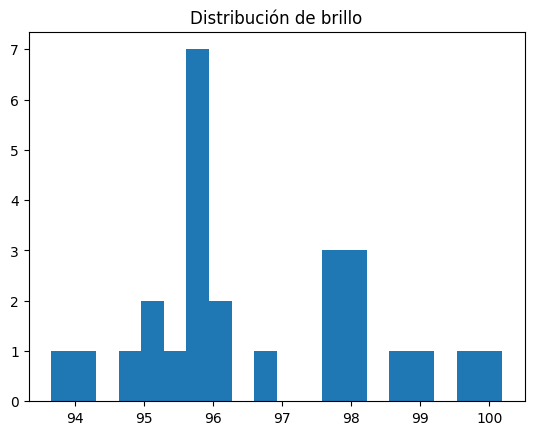

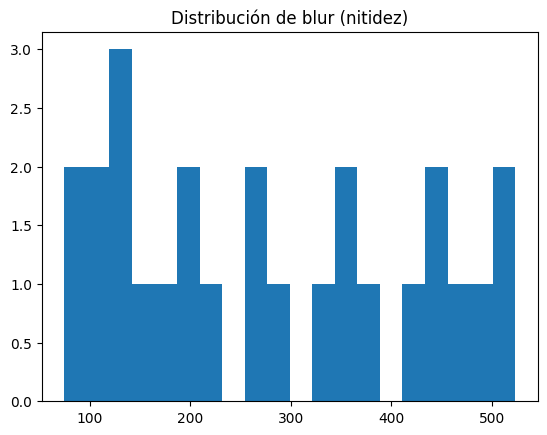

In [8]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(df_stats["brightness"], bins=20)
plt.title("Distribución de brillo")
plt.show()

plt.figure()
plt.hist(df_stats["blur"], bins=20)
plt.title("Distribución de blur (nitidez)")
plt.show()

# Avance 1. Analisis Bi/Multivariable

Correlación Pearson (brightness vs blur): -0.16713418126950058


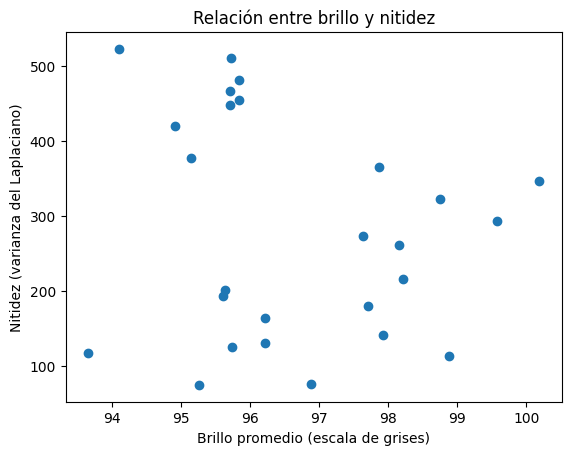

In [9]:
import matplotlib.pyplot as plt
import numpy as np

corr = df_stats["brightness"].corr(df_stats["blur"], method="pearson")
print("Correlación Pearson (brightness vs blur):", corr)

plt.figure()
plt.scatter(df_stats["brightness"], df_stats["blur"])
plt.xlabel("Brillo promedio (escala de grises)")
plt.ylabel("Nitidez (varianza del Laplaciano)")
plt.title("Relación entre brillo y nitidez")
plt.show()

In [10]:
#Creación de Rangos de Nitidez
# Se toma la mediana de la variable como umbral, determinando el valor de nitidez de una imagen como menor si está
# por dejabo o mayor / High si está por encima.

df_stats["blur_level"] = np.where(
    df_stats["blur"] < df_stats["blur"].median(), "low", "high"
)

# Se aplica el mismo criterio sobre el brillo

df_stats["brightness_level"] = np.where(
    df_stats["brightness"] < df_stats["brightness"].median(), "low", "high"
)

pd.crosstab(df_stats["blur_level"], df_stats["brightness_level"])

brightness_level  high  low
blur_level                 
high                 5    8
low                  8    5

# Avance 1. Preprocesamiento

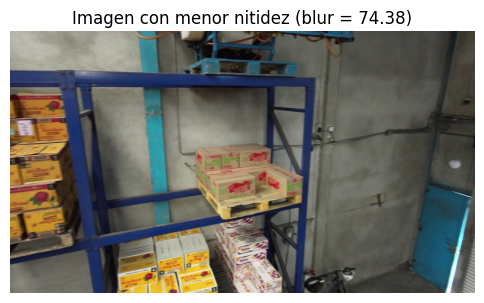

In [11]:
import cv2
import matplotlib.pyplot as plt

worst_row = df_stats.loc[df_stats["blur"].idxmin()]
worst_image_path = worst_row["path"]
worst_blur_value = worst_row["blur"]

img = cv2.imread(worst_image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,4))
plt.imshow(img_rgb)
plt.title(f"Imagen con menor nitidez (blur = {worst_blur_value:.2f})")
plt.axis("off")
plt.show()

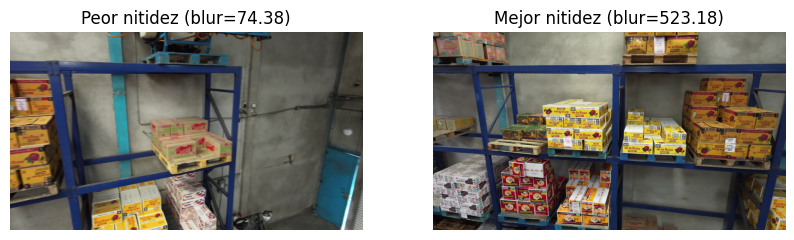

In [12]:
# Comparar peor y mejor imagen
best_row = df_stats.loc[df_stats["blur"].idxmax()]

img_worst = cv2.cvtColor(cv2.imread(worst_row["path"]), cv2.COLOR_BGR2RGB)
img_best  = cv2.cvtColor(cv2.imread(best_row["path"]), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(img_worst)
plt.title(f"Peor nitidez (blur={worst_row['blur']:.2f})")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_best)
plt.title(f"Mejor nitidez (blur={best_row['blur']:.2f})")
plt.axis("off")

plt.show()

In [13]:
# Aplicamos el filtro de Imagen acuerdo a la nitidez
import numpy as np

# Umbral: primer cuartil (25%) de blur
blur_threshold = df_stats["blur"].quantile(0.25)

df_filtered = df_stats[df_stats["blur"] >= blur_threshold].copy()
df_discarded = df_stats[df_stats["blur"] < blur_threshold].copy()

print("Total original:", len(df_stats))
print("Descartadas (blur bajo):", len(df_discarded))
print("Restantes:", len(df_filtered))
print("Umbral blur (Q1):", blur_threshold)


Total original: 26
Descartadas (blur bajo): 7
Restantes: 19
Umbral blur (Q1): 146.6739427950466


In [14]:
import os
import shutil

# Carpeta destino en inglés
processed_dir = os.path.join(base_dir, "data", "Processed Images")
os.makedirs(processed_dir, exist_ok=True)

# Copiar imágenes filtradas manteniendo el nombre original
for src_path in df_filtered["path"]:
    filename = os.path.basename(src_path)  # frame_000XXX.jpg
    dst_path = os.path.join(processed_dir, filename)
    shutil.copy2(src_path, dst_path)

print(f"{len(df_filtered)} images copied to:\n{processed_dir}")

19 images copied to:
/content/drive/MyDrive/Proyecto Integrador Equipo37/Video Segmentation/data/Processed Images


In [15]:
filtered_csv_path = "/content/drive/MyDrive/Proyecto Integrador Equipo37/Video Segmentation/data/eda/frames_eda_filtered.csv"
df_filtered.to_csv(filtered_csv_path, index=False)
print("CSV filtrado guardado en:", filtered_csv_path)

CSV filtrado guardado en: /content/drive/MyDrive/Proyecto Integrador Equipo37/Video Segmentation/data/eda/frames_eda_filtered.csv


# Avance # 2. Ingeniería de Características

In [16]:
# Creación de nuevas caracteristicas desde las imagenes filtradas del Avance 1.
import os, glob
import numpy as np
import pandas as pd
import cv2

def compute_entropy(gray: np.ndarray, bins: int = 256) -> float:
    """Entropía de intensidades en escala de grises."""
    hist = cv2.calcHist([gray], [0], None, [bins], [0, 256]).ravel()
    p = hist / (hist.sum() + 1e-12)
    p = p[p > 0]
    return float(-(p * np.log2(p)).sum())

def compute_edge_density(gray: np.ndarray) -> float:
    """
    Densidad de bordes usando Canny con umbrales automáticos basados en la mediana.
    """
    med = np.median(gray)
    lower = int(max(0, 0.66 * med))
    upper = int(min(255, 1.33 * med))
    edges = cv2.Canny(gray, lower, upper)
    return float(np.count_nonzero(edges) / edges.size)

def extract_features_from_image(img_path: str) -> dict:
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        return {"_read_error": 1}

    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    hsv  = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    brightness = float(np.mean(gray))
    blur = float(cv2.Laplacian(gray, cv2.CV_64F).var())

    # Construcción de nuevas características
    contrast = float(np.std(gray))                 # variación de intensidad
    edge_density = compute_edge_density(gray)      # proxy de contornos/cajas visibles
    entropy = compute_entropy(gray)                # textura/variabilidad
    saturation_mean = float(np.mean(hsv[:, :, 1])) # robustez ante iluminación

    # Caracteristicas derivadas/transformaciones
    sharpness_norm = float(blur / (brightness + 1e-6))
    log_blur = float(np.log(blur + 1e-6))

    return {
        "brightness": brightness,
        "blur": blur,
        "contrast": contrast,
        "edge_density": edge_density,
        "entropy": entropy,
        "saturation_mean": saturation_mean,
        "sharpness_norm": sharpness_norm,
        "log_blur": log_blur,
        "_read_error": 0
    }

# Lectura de Imagenes
processed_files = sorted(glob.glob(os.path.join(processed_dir, "*.jpg")) +
                         glob.glob(os.path.join(processed_dir, "*.png")))

print("Imágenes en Processed Images:", len(processed_files))
if len(processed_files) == 0:
    raise ValueError("No hay imágenes en Processed Images. Revisa processed_dir.")

# Extracción de Caracteristicas
rows = []
for p in processed_files:
    feats = extract_features_from_image(p)
    rows.append({
        "filename": os.path.basename(p),
        "processed_path": p,
        **feats
    })

df_fe = pd.DataFrame(rows)
df_fe = df_fe[df_fe["_read_error"] == 0].drop(columns=["_read_error"]).copy()

# Integración con df_filtered (trazabilidad)
# df_filtered ya tiene filename/path/brightness/blur (de sampled_dir). Se Conserva ambos y agregamos nuevas features.
df_ready = df_filtered.drop(columns=[c for c in ["brightness","blur"] if c in df_filtered.columns], errors="ignore") \
                      .merge(df_fe, on="filename", how="inner")

print("df_filtered:", len(df_filtered))
print("df_fe:", len(df_fe))
print("df_ready (merge):", len(df_ready))
df_ready.head()


Imágenes en Processed Images: 19
df_filtered: 19
df_fe: 19
df_ready (merge): 19


filename                                               path  \
0  frame_000030.jpg  /content/drive/MyDrive/Proyecto Integrador Equ...   
1  frame_000060.jpg  /content/drive/MyDrive/Proyecto Integrador Equ...   
2  frame_000090.jpg  /content/drive/MyDrive/Proyecto Integrador Equ...   
3  frame_000240.jpg  /content/drive/MyDrive/Proyecto Integrador Equ...   
4  frame_000270.jpg  /content/drive/MyDrive/Proyecto Integrador Equ...   

  blur_level brightness_level  \
0        low             high   
1        low              low   
2        low              low   
3        low             high   
4        low             high   

                                      processed_path  brightness        blur  \
0  /content/drive/MyDrive/Proyecto Integrador Equ...   96.214860  163.124427   
1  /content/drive/MyDrive/Proyecto Integrador Equ...   95.633990  200.598275   
2  /content/drive/MyDrive/Proyecto Integrador Equ...   95.607826  193.733635   
3  /content/drive/MyDrive/Proyecto Integrador Equ...   97.708086  180.046116   
4  /content/drive/MyDrive/Proyecto Integrador Equ...   98.216906  216.369864   

    contrast  edge_density   entropy  saturation_mean  sharpness_norm  \
0  46.328063      0.051737  7.449564        65.713707        1.695418   
1  49.246988      0.063059  7.529134        73.076691        2.097563   
2  45.838001      0.056223  7.438778        68.080217        2.026337   
3  44.506192      0.057553  7.423158        57.217865        1.842694   
4  43.798871      0.062733  7.409961        56.854243        2.202980   

   log_blur  
0  5.094513  
1  5.301304  
2  5.266484  
3  5.193213  
4  5.376989

Se identificaron 19 imágenes, mismas del resultado del avance # 1 y el merge mantuvo sus observaciones: df_filtered: 19, df_fe: 19, df_ready: 19.
El dataframe final df_ready integra trazabilidad con los campos de: filename, path, processed_path y agrega métricas nuevas por imagen como lo es: brightness, blur y variables derivadas como contraste, densidad de bordes, entropía, saturación. Esto confirma que el subconjunto filtrado del Avance 1 se transformó correctamente en un dataset estructurado para ingeniería de características.

In [17]:
# Discretización (binning) + codificación Ordinario/Binario
import numpy as np

# Binning por cuantiles para blur (3 niveles)
q1, q2 = df_ready["blur"].quantile([0.33, 0.66]).values
def blur_level(x):
    if x < q1:
        return "low"
    elif x < q2:
        return "medium"
    return "high"

df_ready["blur_level"] = df_ready["blur"].apply(blur_level)

# Binning por mediana para brightness (2 niveles)
b_med = df_ready["brightness"].median()
df_ready["brightness_level"] = (df_ready["brightness"] >= b_med).astype(int)  # 0 bajo, 1 alto

# Codificación ordinal para blur_level
blur_map = {"low": 0, "medium": 1, "high": 2}
df_ready["blur_level_ord"] = df_ready["blur_level"].map(blur_map).astype(int)

print("Umbrales blur:", q1, q2)
print("Mediana brightness:", b_med)
df_ready[["filename","brightness","blur","blur_level","blur_level_ord","brightness_level"]].head()

Umbrales blur: 273.1436158782971 415.4522724256654
Mediana brightness: 95.84145543981481


filename  brightness        blur blur_level  blur_level_ord  \
0  frame_000030.jpg   96.214860  163.124427        low               0   
1  frame_000060.jpg   95.633990  200.598275        low               0   
2  frame_000090.jpg   95.607826  193.733635        low               0   
3  frame_000240.jpg   97.708086  180.046116        low               0   
4  frame_000270.jpg   98.216906  216.369864        low               0   

   brightness_level  
0                 1  
1                 0  
2                 0  
3                 1  
4                 1

Se calcularon umbrales de blur por cuantiles: q1 = 273.14 y q2 = 415.45, y una mediana de brightness de 95.84. Con esto, se generaron variables categóricas y codificadas: blur_level: low/medium/high y brightness_level como 0=bajo, 1=alto, además de blur_level_ord como: 0,1,2.
La tabla de salida muestra ejemplos con blur_level = low y distintos niveles de brillo, en esta etapa no se filtra imágenes, sino que transforma variables continuas a representaciones discretas/ordinales para facilitar análisis, interpretabilidad y uso posterior en modelos.

In [18]:
# Normalización / escalamiento + ya se cuenta con log_blur
from sklearn.preprocessing import StandardScaler

# Features numéricas para modelado (incluimos ordinal y binarias si lo desean)
feature_cols = [
    "brightness", "blur", "log_blur",
    "contrast", "edge_density", "entropy", "saturation_mean", "sharpness_norm",
    "blur_level_ord", "brightness_level"
]

X = df_ready[feature_cols].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

df_scaled = pd.DataFrame(X_scaled, columns=[f"{c}_z" for c in feature_cols])
df_scaled.insert(0, "filename", df_ready["filename"].values)

print("Matriz escalada:", df_scaled.shape)
df_scaled.head()

Matriz escalada: (19, 11)


filename  brightness_z    blur_z  log_blur_z  contrast_z  \
0  frame_000030.jpg     -0.334285 -1.535658   -1.822534   -1.422124   
1  frame_000060.jpg     -0.686605 -1.214197   -1.264938   -0.500252   
2  frame_000090.jpg     -0.702474 -1.273083   -1.358828   -1.576898   
3  frame_000240.jpg      0.571415 -1.390499   -1.556398   -1.997518   
4  frame_000270.jpg      0.880034 -1.078903   -1.060860   -2.220908   

   edge_density_z  entropy_z  saturation_mean_z  sharpness_norm_z  \
0       -1.866355  -1.568779          -1.455188         -1.491049   
1       -1.179385  -0.544520          -0.796406         -1.166953   
2       -1.594166  -1.707622          -1.243451         -1.224356   
3       -1.513492  -1.908691          -2.215329         -1.372356   
4       -1.199136  -2.078567          -2.247863         -1.081996   

   blur_level_ord_z  brightness_level_z  
0         -1.275153            0.948683  
1         -1.275153           -1.054093  
2         -1.275153           -1.054093  
3         -1.275153            0.948683  
4         -1.275153            0.948683

Se construyó una matriz escalada con forma de (19, 11), generando columnas con sufijo _z para todas las features numéricas seleccionadas.
Los valores resultantes son z-scores es decir centrados y escalados, lo que permite que variables con escalas muy distintas por ejemplo, blur y edge_density tengan impacto equitativo en etapas posteriores como selección, PCA o algoritmos basados en distancia.

In [19]:
# Selección donde se aplica filtrado: Umbral de varianza + Correlación
from sklearn.feature_selection import VarianceThreshold

# 1) Umbral de varianza (sobre variables escaladas)
Xz = df_scaled.drop(columns=["filename"])
vt = VarianceThreshold(threshold=0.01)  # pequeño porque ya está escalado
X_vt = vt.fit_transform(Xz)

kept_cols_vt = Xz.columns[vt.get_support()].tolist()
removed_cols_vt = [c for c in Xz.columns if c not in kept_cols_vt]

print("Features originales:", Xz.shape[1])
print("Features tras varianza:", len(kept_cols_vt))
print("Eliminadas por varianza baja:", removed_cols_vt)

df_vt = pd.DataFrame(X_vt, columns=kept_cols_vt)
df_vt.insert(0, "filename", df_scaled["filename"].values)

# 2) Filtrado por correlación ( para quitar redundancia)
corr = df_vt.drop(columns=["filename"]).corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop_corr = [col for col in upper.columns if any(upper[col] > 0.90)]

print("Eliminadas por correlación alta (>0.90):", to_drop_corr)

df_sel = df_vt.drop(columns=to_drop_corr).copy()
print("Features finales tras selección:", df_sel.shape)
df_sel.head()

Features originales: 10
Features tras varianza: 10
Eliminadas por varianza baja: []
Eliminadas por correlación alta (>0.90): ['log_blur_z', 'edge_density_z', 'entropy_z', 'saturation_mean_z', 'sharpness_norm_z', 'blur_level_ord_z']
Features finales tras selección: (19, 5)


filename  brightness_z    blur_z  contrast_z  brightness_level_z
0  frame_000030.jpg     -0.334285 -1.535658   -1.422124            0.948683
1  frame_000060.jpg     -0.686605 -1.214197   -0.500252           -1.054093
2  frame_000090.jpg     -0.702474 -1.273083   -1.576898           -1.054093
3  frame_000240.jpg      0.571415 -1.390499   -1.997518            0.948683
4  frame_000270.jpg      0.880034 -1.078903   -2.220908            0.948683

Despues de aplicar VarianceThreshold, no se eliminó ninguna variable por baja varianza, indicando que todas las features aportan variabilidad en el subconjunto procesado. Luego, el filtro por correlación removió variables altamente redundantes: log_blur_z, edge_density_z, entropy_z, saturation_mean_z, sharpness_norm_z, blur_level_ord_z. El dataset final quedó con (19, 5) columnas incluyendo filename, preservando un conjunto compacto de features no redundantes por ejemplo, brightness_z, blur_z, contrast_z, brightness_level_z y reduciendo complejidad sin perder representatividad.

Componentes totales: 4
k (>=90% varianza): 3
Varianza acumulada en k: 0.9541600150501145


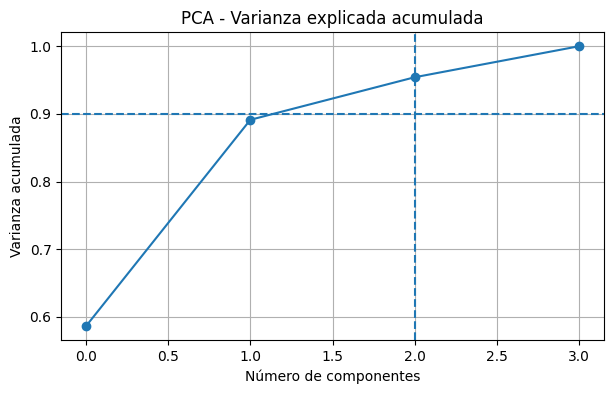

filename       PC1       PC2       PC3
0  frame_000030.jpg  1.706387 -1.373387  0.084383
1  frame_000060.jpg -0.094036 -1.519265 -0.993862
2  frame_000090.jpg  0.320536 -2.304731 -0.444288
3  frame_000240.jpg  2.301895 -1.284442  0.445193
4  frame_000270.jpg  2.371902 -1.177264  0.772754

In [20]:
# Extracción: PCA reduce dimensionalidad + varianza explicada
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X_sel = df_sel.drop(columns=["filename"]).values

pca = PCA()
X_pca_all = pca.fit_transform(X_sel)

explained = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained)

# Elegir k para cubrir 90% de varianza
k = int(np.argmax(cum_explained >= 0.90) + 1)

print("Componentes totales:", len(explained))
print("k (>=90% varianza):", k)
print("Varianza acumulada en k:", cum_explained[k-1])

# Grafica de varianza acumulada
plt.figure(figsize=(7,4))
plt.plot(cum_explained, marker="o")
plt.axhline(0.90, linestyle="--")
plt.axvline(k-1, linestyle="--")
plt.title("PCA - Varianza explicada acumulada")
plt.xlabel("Número de componentes")
plt.ylabel("Varianza acumulada")
plt.grid(True)
plt.show()

# Dataset PCA final
df_pca = pd.DataFrame(X_pca_all[:, :k], columns=[f"PC{i+1}" for i in range(k)])
df_pca.insert(0, "filename", df_sel["filename"].values)

df_pca.head()

Se aplicó PCA sobre las features seleccionadas y se obtuvieron 4 componentes totales, determinando que el numero de componentes principales es decir k; es igual a 3; dichos componentes explican al menos el 90% de la varianza, con una varianza acumulada de 0.9542 (95.42%). El resultado se almacena como un dataset reducido con columnas PC1, PC2, PC3, donde cada imagen queda representada en un espacio de menor dimensión que conserva la mayor parte de la información original. La gráfica de varianza explicada acumulada respalda visualmente la decisión de k y justifica formalmente la extracción de características.

In [21]:
# Guardamos documentos de Ingenieria de caracteristicas (features, escalado, selección, PCA)
out_dir = os.path.join(base_dir, "data", "fe")
os.makedirs(out_dir, exist_ok=True)

paths = {
    "features_full": os.path.join(out_dir, "frames_features_full.csv"),
    "features_scaled": os.path.join(out_dir, "frames_features_scaled.csv"),
    "features_selected": os.path.join(out_dir, "frames_features_selected.csv"),
    "features_pca": os.path.join(out_dir, "frames_features_pca.csv"),
}

df_ready.to_csv(paths["features_full"], index=False)
df_scaled.to_csv(paths["features_scaled"], index=False)
df_sel.to_csv(paths["features_selected"], index=False)
df_pca.to_csv(paths["features_pca"], index=False)

print("Archivos guardados:")
for k,v in paths.items():
    print(f"- {k}: {v}")

Archivos guardados:
- features_full: /content/drive/MyDrive/Proyecto Integrador Equipo37/Video Segmentation/data/fe/frames_features_full.csv
- features_scaled: /content/drive/MyDrive/Proyecto Integrador Equipo37/Video Segmentation/data/fe/frames_features_scaled.csv
- features_selected: /content/drive/MyDrive/Proyecto Integrador Equipo37/Video Segmentation/data/fe/frames_features_selected.csv
- features_pca: /content/drive/MyDrive/Proyecto Integrador Equipo37/Video Segmentation/data/fe/frames_features_pca.csv


Se generaron y guardaron cuatro archivos CSV en la ruta del Avance 2 de Ingenieria de caracteristicas. Los 4 documentos son: frames_features_full.csv mismo que contiene los features completas ; frames_features_scaled.csv que son los features normalizadas; frames_features_selected.csv que son los features tras selección y finalmente frames_features_pca.csv que es la representación PCA. Esto consolida la evidencia del Avance 2

# Conclusión del Avance # 2

Avance 2 se realizó ingeniería de características sobre el subconjunto de imágenes previamente depurado por calidad (filtrado por blur en Avance 1), transformando datos visuales crudos en un conjunto estructurado de variables numéricas útiles para aprendizaje automático. Se construyeron características adicionales orientadas al dominio como por ejemplo: contraste, textura y proxies de contorno y se aplicaron discretización/codificación para mejorar interpretabilidad. Posteriormente, se estandarizaron las variables mediante z-score para evitar sesgos por escala y favorecer estabilidad en algoritmos posteriores. Finalmente, se redujo la complejidad mediante selección por filtrado (varianza y correlación) y extracción con PCA, conservando ~95% de la varianza con solo 3 componentes principales.

En el contexto de CRISP-ML, estas acciones fortalecen la fase de Preparación de los Datos, mitigando riesgos de sesgo y dejando el dataset listo y trazable para la siguiente etapa de modelado del conteo e identificación de cajas por pallet.

# Avance 3 Baseline

# Algoritmo para Conteo de Cajas

# CLIP (Contrastive Language–Image Pretraining)

**Concepto de CLIP:**

CLIP es un modelo multimodal desarrollado por OpenAI que aprende representaciones conjuntas entre imágenes y texto. Fue entrenado mediante aprendizaje contrastivo sobre cientos de millones de pares imagen–texto disponibles en la web, lo que le permite asociar contenido visual con descripciones semánticas en lenguaje natural.

A diferencia de modelos tradicionales entrenados específicamente para clasificación o detección, CLIP no requiere entrenamiento adicional para reconocer nuevas categorías. Puede evaluar si una imagen corresponde a un concepto textual simplemente midiendo similitud entre embeddings visuales y embeddings de texto.

**Ejemplo de Uso:**

Un ejemplo del uso de clip aplicado a nuestro proyuecto, constaria del siguiente pipeline:

1.-Se selecciona una región de la imagen (ROI) donde se encuentran los pallets.

2.-Esta región se divide en múltiples ventanas deslizantes.

3.-Cada ventana se evalúa mediante CLIP comparándola contra descripciones textuales como:“a product packaging box”, “stacked cardboard boxes”, “a metal shelf", “a concrete wall”.


4.-CLIP convierte tanto la imagen (ventana) como cada descripción textual en vectores numéricos (embeddings).

5.-Se calcula la similitud coseno entre la ventana y cada descripción.

6.-Si la similitud con descripciones de “caja” es mayor que con descripciones negativas, la ventana se clasifica como región con presencia de cajas.

**Estructura Interna y Funcionamiento**

CLIP está compuesto por dos redes principales:

1.- Encoder Visual

Puede ser una arquitectura ResNet o Vision Transformer (ViT).Convierte la imagen en un vector de características (embedding visual).

2.- Encoder de Texto
Basado en Transformer; Convierte una descripción textual en un embedding semántico en el mismo espacio latente que las imágenes.

Durante el entrenamiento, el modelo aprende a maximizar la similitud entre la imagen y su texto correspondiente, mientras minimiza la similitud con textos no relacionados. Esto genera un espacio compartido donde imágenes y descripciones similares se encuentran cercanas.

En inferencia, el proceso es:

1.- Se codifica la imagen.

2.- Se codifican varias descripciones textuales.

3.- Se calcula similitud coseno entre embeddings.

4.- La mayor similitud determina la correspondencia semántica.

**Aplicación de CLIP (ROI - Region of Interest: Toda la imagen)**

In [48]:
# Celda 0 - Configuramos el uso para CPU y montamos el drive

import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

from google.colab import drive
drive.mount('/content/drive')

import torch
device = torch.device("cpu")
torch.set_default_device("cpu")

print("Torch default device:", torch.get_default_device())
print("CUDA available:", torch.cuda.is_available())
print("Using device:", device)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Torch default device: cpu
CUDA available: False
Using device: cpu


In [49]:
# Celda A - Preparacion de librerias necesarias. Uso del CPU y sin ROI Fijo se usa toda la imagen

import numpy as np
import torch
from PIL import Image
from torchvision.ops import nms

device = torch.device("cpu")

def get_pallet_roi_bbox(frame_pil: Image.Image, meta=None):
    """
    SIN ROI: usa toda la imagen.
    (meta queda para futuro si quieres bbox real del pallet)
    """
    if meta and "pallet_bbox" in meta and meta["pallet_bbox"] is not None:
        return tuple(meta["pallet_bbox"])
    w, h = frame_pil.size
    return (0, 0, w, h)

def crop_roi(frame_pil: Image.Image, roi_bbox):
    x1, y1, x2, y2 = map(int, roi_bbox)
    return frame_pil.crop((x1, y1, x2, y2)), (x1, y1, x2, y2)

def generate_grid_boxes(w, h,
                        window_sizes=(160, 192, 224),
                        strides=(48, 64, 80)):
    """
    Grid más denso (más ventanas) para intentar capturar cajas individuales.
    Nota: más ventanas = más tiempo en CPU.
    """
    assert len(window_sizes) == len(strides)
    boxes = []
    for ws, st in zip(window_sizes, strides):
        if ws > w or ws > h:
            continue
        for y in range(0, h - ws + 1, st):
            for x in range(0, w - ws + 1, st):
                boxes.append([x, y, x + ws, y + ws])
    return np.array(boxes, dtype=np.float32)

def crop_boxes_from_roi(roi_pil: Image.Image, boxes_xyxy):
    crops = []
    for x1, y1, x2, y2 in boxes_xyxy:
        crops.append(roi_pil.crop((int(x1), int(y1), int(x2), int(y2))))
    return crops

def nms_count(boxes_xyxy, scores,
              iou_thr=0.45,
              score_thr=0.0):
    if len(boxes_xyxy) == 0:
        return 0, np.array([], dtype=int)

    boxes = torch.tensor(boxes_xyxy, device="cpu")
    scr = torch.tensor(scores, device="cpu")

    keep_mask = scr >= float(score_thr)
    boxes = boxes[keep_mask]
    scr = scr[keep_mask]

    if boxes.numel() == 0:
        return 0, np.array([], dtype=int)

    keep_idx = nms(boxes, scr, float(iou_thr))
    return int(len(keep_idx)), keep_idx.detach().cpu().numpy()

In [50]:
# Celda B usamos Clip en CPU + scoring batch

!pip -q install open_clip_torch

import open_clip
import numpy as np
import torch
import torch.nn.functional as F

device = torch.device("cpu")

clip_model_name = "ViT-B-32"
clip_pretrained = "openai"

clip_model, _, clip_preprocess = open_clip.create_model_and_transforms(
    clip_model_name, pretrained=clip_pretrained
)
clip_model = clip_model.to(device).eval()
clip_tokenizer = open_clip.get_tokenizer(clip_model_name)

# Prompts positivos (cajas de producto / packaging)
POS_PROMPTS = [
    "a product packaging box",
    "a printed cardboard carton",
    "stacked boxes in a warehouse",
    "boxes on a pallet",
    "cardboard packaging"
]

# Prompts negativos (para bajar pared/estructura)
NEG_PROMPTS = [
    "a concrete wall",
    "an empty concrete wall",
    "electrical cables on a wall",
    "a blue metal shelf frame",
    "a metal shelf structure",
    "warehouse floor",
    "an empty shelf"
]

@torch.no_grad()
def clip_scores_for_crops(crops_pil, batch_size=64):
    # Texto (precomputado una vez por llamada)
    pos = clip_tokenizer(POS_PROMPTS).to(device)
    neg = clip_tokenizer(NEG_PROMPTS).to(device)

    pos_f = F.normalize(clip_model.encode_text(pos), dim=-1)
    neg_f = F.normalize(clip_model.encode_text(neg), dim=-1)

    scores_all = []
    for i in range(0, len(crops_pil), batch_size):
        batch = crops_pil[i:i+batch_size]
        img = torch.stack([clip_preprocess(c) for c in batch]).to(device)

        img_f = F.normalize(clip_model.encode_image(img), dim=-1)

        pos_sim = (img_f @ pos_f.T).max(dim=1).values
        neg_sim = (img_f @ neg_f.T).max(dim=1).values

        score = (pos_sim - neg_sim).detach().cpu().numpy()
        scores_all.append(score)

    return np.concatenate(scores_all, axis=0)

def predict_count_clip_only(frame_pil, meta=None,
                            window_sizes=(160,192,224),
                            strides=(48,64,80),
                            thr_percentile=95,
                            iou_thr=0.45,
                            batch_size=64):

    roi_bbox = get_pallet_roi_bbox(frame_pil, meta)
    roi_pil, _ = crop_roi(frame_pil, roi_bbox)
    w, h = roi_pil.size

    boxes = generate_grid_boxes(w, h, window_sizes, strides)
    if len(boxes) == 0:
        return 0

    crops = crop_boxes_from_roi(roi_pil, boxes)
    scores = clip_scores_for_crops(crops, batch_size=batch_size)

    score_thr = float(np.percentile(scores, thr_percentile))
    count, _ = nms_count(boxes, scores, iou_thr=iou_thr, score_thr=score_thr)
    return count

/usr/local/lib/python3.12/dist-packages/open_clip/factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


Total seleccionados: 19
Primer filename: frame_000030.jpg
Ruta: /content/drive/MyDrive/Proyecto Integrador Equipo37/Video Segmentation/data/Processed Images/frame_000030.jpg
Existe?: True


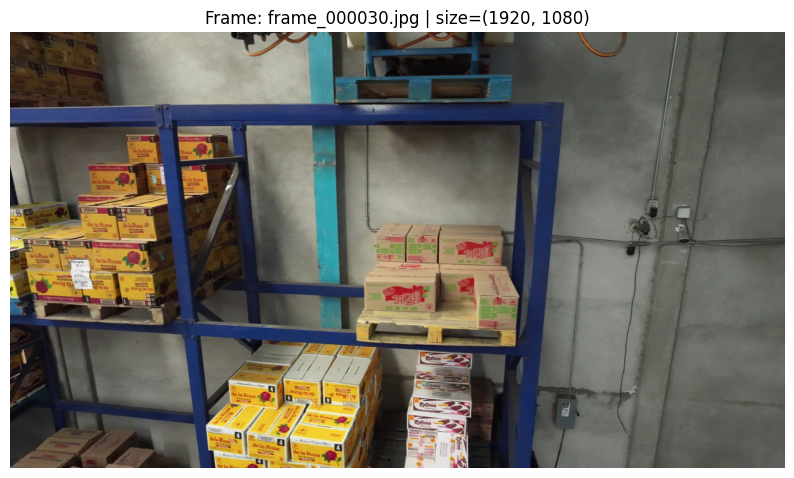

In [51]:
# Celda C: Cargar CSV + abrir primer frame

import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

CSV_PATH = "/content/drive/MyDrive/Proyecto Integrador Equipo37/Video Segmentation/data/fe/frames_features_selected.csv"
FRAMES_DIR = "/content/drive/MyDrive/Proyecto Integrador Equipo37/Video Segmentation/data/Processed Images"

df_sel = pd.read_csv(CSV_PATH)
selected_filenames = df_sel["filename"].tolist()

print("Total seleccionados:", len(selected_filenames))
print("Primer filename:", selected_filenames[0])

first_path = os.path.join(FRAMES_DIR, selected_filenames[0])
print("Ruta:", first_path)
print("Existe?:", os.path.exists(first_path))

img = Image.open(first_path).convert("RGB")

plt.figure(figsize=(10,6))
plt.imshow(img)
plt.axis("off")
plt.title(f"Frame: {selected_filenames[0]} | size={img.size}")
plt.show()

In [52]:
# Celda D: Conteo CLIP-only (1 frame)

count_clip = predict_count_clip_only(
    img,
    window_sizes=(160,192,224),
    strides=(48,64,80),
    thr_percentile=95,
    iou_thr=0.45
)
print("CLIP-only count:", count_clip)

CLIP-only count: 27


ROI size: (1920, 1080) | Num windows: 1374
Scores min/mean/max: -0.08239051699638367 -0.010182040743529797 0.08019271492958069
p90: 0.03024846874177456
p95: 0.037914421409368515
p97: 0.04273073002696037
p99: 0.05291823297739029
Using adaptive score_thr: 0.037914421409368515


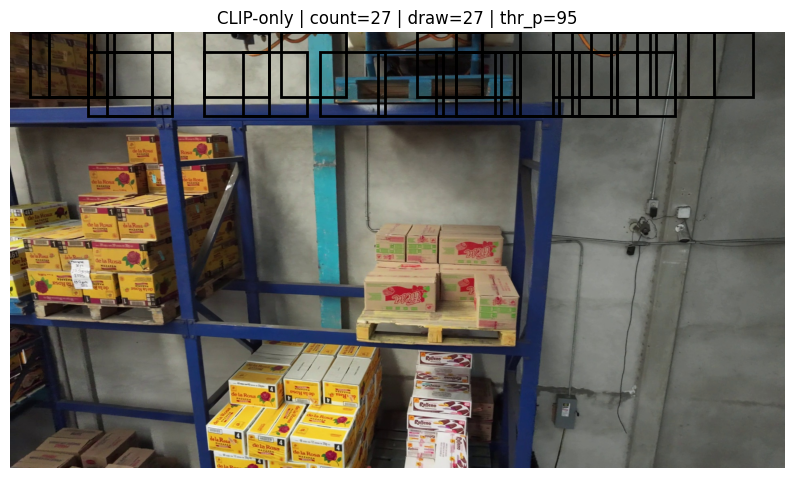

27

In [53]:
# Celda E: Debug visual CLIP-only (SIN ROI) - CPU

import numpy as np
import matplotlib.pyplot as plt

def debug_clip_boxes(frame_pil, meta=None,
                     window_sizes=(160,192,224),
                     strides=(48,64,80),
                     thr_percentile=95,
                     iou_thr=0.45,
                     topk_draw=80,
                     batch_size=64):

    roi_bbox = get_pallet_roi_bbox(frame_pil, meta)
    roi_pil, _ = crop_roi(frame_pil, roi_bbox)
    w, h = roi_pil.size

    boxes = generate_grid_boxes(w, h, window_sizes, strides)
    print("ROI size:", (w, h), "| Num windows:", len(boxes))

    crops = crop_boxes_from_roi(roi_pil, boxes)
    scores = clip_scores_for_crops(crops, batch_size=batch_size)

    print("Scores min/mean/max:",
          float(scores.min()),
          float(scores.mean()),
          float(scores.max()))
    for p in [90, 95, 97, 99]:
        print(f"p{p}:", float(np.percentile(scores, p)))

    score_thr = float(np.percentile(scores, thr_percentile))
    print("Using adaptive score_thr:", score_thr)

    count, keep_idx = nms_count(boxes, scores, iou_thr=iou_thr, score_thr=score_thr)

    if len(keep_idx) == 0:
        print("No boxes survived threshold + NMS")
        plt.figure(figsize=(10,6))
        plt.imshow(roi_pil)
        plt.axis("off")
        plt.title("CLIP-only | count=0")
        plt.show()
        return 0

    kept_scores = scores[keep_idx]
    order = np.argsort(-kept_scores)
    keep_idx = keep_idx[order][:topk_draw]

    fig, ax = plt.subplots(figsize=(10,6))
    ax.imshow(roi_pil)
    ax.axis("off")
    ax.set_title(f"CLIP-only | count={count} | draw={len(keep_idx)} | thr_p={thr_percentile}")

    for i in keep_idx:
        x1, y1, x2, y2 = boxes[i]
        ax.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, linewidth=2))

    plt.show()
    return count

debug_clip_boxes(
    img,
    window_sizes=(160,192,224),
    strides=(48,64,80),
    thr_percentile=95,
    iou_thr=0.45,
    topk_draw=80
)

**Aplicación de CLIP (ROI - Region of Interest: 1 Palet)**

In [60]:
# ROI manual
MANUAL_ROI = (820, 360, 1450, 850)  # (x1,y1,x2,y2)

def get_pallet_roi_bbox(frame_pil, meta=None):
    if meta and "pallet_bbox" in meta and meta["pallet_bbox"] is not None:
        return tuple(meta["pallet_bbox"])
    return MANUAL_ROI

ROI size: (630, 490) | Num windows: 129
Scores min/mean/max: -0.04566153883934021 0.02049243450164795 0.07495853304862976
p90: 0.04588356986641884
p95: 0.054768823087215424
p97: 0.059332773089408875
p99: 0.06629331409931183
Using adaptive score_thr: 0.054768823087215424


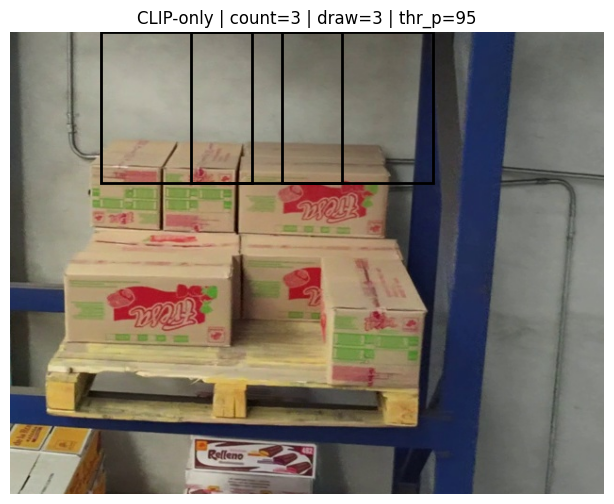

3

In [61]:
debug_clip_boxes(img)

ROI size: (630, 490) | Num windows: 160
Scores min/mean/max: -0.05578434467315674 0.010398762300610542 0.07164224982261658
p90: 0.04234541580080986
p95: 0.047204457223415375
p97: 0.05501594766974449
p99: 0.06776221096515656
Using adaptive score_thr: 0.047204457223415375


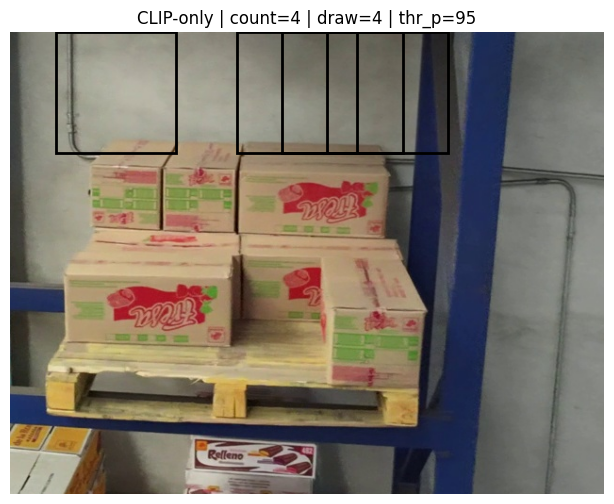

4

In [62]:
debug_clip_boxes(
    img,
    window_sizes=(128, 160, 192),
    strides=(48, 64, 80),
    thr_percentile=95,
    iou_thr=0.45,
    topk_draw=80
)

**Conclusiones del algoritmo CLIP para conteo de cajas**

Si bien CLIP demuestra capacidad para reconocer presencia de cajas, su desempeño en tareas de conteo de instancias es limitado debido a que:

1.- No realiza segmentación por objeto.

2.- No genera bounding boxes nativas.

3.- No fue diseñado para detección ni conteo explícito.

Por lo tanto, CLIP se considera más adecuado para la etapa posterior de identificación de producto, donde puede validar semánticamente cada caja previamente segmentada por un modelo como SAM.

Este análisis justifica la necesidad de incorporar modelos especializados en segmentación para lograr un conteo más preciso.


# DinoV2

**Concepto de DinoV2:**

DINOv2 (Distillation with NO labels v2) es un modelo de visión computacional basado en arquitecturas Vision Transformer (ViT), entrenado mediante aprendizaje auto-supervisado. A diferencia de modelos supervisados tradicionales, DINOv2 aprende representaciones visuales generales sin necesidad de etiquetas manuales.

Su objetivo principal es generar embeddings visuales robustos y semánticamente ricos, capaces de capturar información estructural y contextual de una imagen. Estos embeddings pueden utilizarse posteriormente para tareas como clasificación, recuperación de imágenes, segmentación o detección mediante métodos adicionales.

**Ejemplo de Uso**

Si consideramos un frame donde existe un pallet con múltiples cajas.

El procedimiento con DINOv2 es:

1.- Se define un ROI correspondiente a un pallet.

2.- Se divide el ROI en ventanas deslizantes.

3.- Cada ventana se convierte en embedding mediante DINOv2.

4.- Se calcula la similitud coseno entre el embedding de la ventana y:
  Un prototipo positivo (cajas) o
  Un prototipo negativo (fondo).
  Aqui se puede aplicar 3 enfoques:  1.- Few Shot con algunos prototipos
  2.- Similitud con 1 unico prototipo/ejemplo
  3.- Clustering (No requiere prototipos)

5.- Se calcula un score:

Score = Similaridad_con_cajas − Similaridad_con_fondo

6.- Las ventanas con mayor score se consideran candidatas.

7.- Se aplica Non-Maximum Suppression (NMS).

8.- El número final de regiones resultantes se utiliza como aproximación al conteo de cajas.

**Estructura Interna y Funcionamiento**

**Aplicación de DinoV2 (ROI: Toda la Imagen)**

In [73]:
# =========================
# (CELDA 0) CPU-ONLY + installs
# =========================
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

import torch
device = torch.device("cpu")
torch.set_default_device("cpu")
print("CUDA available:", torch.cuda.is_available())
print("Using device:", device)

!pip -q install scikit-learn opencv-python

CUDA available: False
Using device: cpu


In [74]:
# =========================
# (CELDA A) Utils: ROI switch + grid + crops + NMS + edge score
# =========================
import numpy as np
import torch
from PIL import Image
from torchvision.ops import nms
import cv2

device = torch.device("cpu")

# ROI switch: primero toda la imagen; luego ROI manual
USE_MANUAL_ROI = False
MANUAL_ROI = (820, 360, 1450, 850)

def get_pallet_roi_bbox(frame_pil: Image.Image, meta=None):
    if meta and "pallet_bbox" in meta and meta["pallet_bbox"] is not None:
        return tuple(meta["pallet_bbox"])
    w, h = frame_pil.size
    return MANUAL_ROI if USE_MANUAL_ROI else (0, 0, w, h)

def crop_roi(frame_pil: Image.Image, roi_bbox):
    x1, y1, x2, y2 = map(int, roi_bbox)
    return frame_pil.crop((x1, y1, x2, y2)), (x1, y1, x2, y2)

def generate_grid_boxes(w, h,
                        window_sizes=(160, 192),      # más estable (menos escalas)
                        strides=(96, 112)):           # menos denso
    assert len(window_sizes) == len(strides)
    boxes = []
    for ws, st in zip(window_sizes, strides):
        if ws > w or ws > h:
            continue
        for y in range(0, h - ws + 1, st):
            for x in range(0, w - ws + 1, st):
                boxes.append([x, y, x + ws, y + ws])
    return np.array(boxes, dtype=np.float32)

def crop_boxes_from_roi(roi_pil: Image.Image, boxes_xyxy):
    return [roi_pil.crop((int(x1), int(y1), int(x2), int(y2))) for x1,y1,x2,y2 in boxes_xyxy]

def nms_count(boxes_xyxy, scores, iou_thr=0.60, score_thr=0.0):
    if len(boxes_xyxy) == 0:
        return 0, np.array([], dtype=int)

    boxes = torch.tensor(boxes_xyxy, device="cpu")
    scr = torch.tensor(scores, device="cpu")

    keep_mask = scr >= float(score_thr)
    boxes = boxes[keep_mask]
    scr = scr[keep_mask]

    if boxes.numel() == 0:
        return 0, np.array([], dtype=int)

    keep_idx = nms(boxes, scr, float(iou_thr))
    return int(len(keep_idx)), keep_idx.detach().cpu().numpy()

def edge_density(pil_img: Image.Image):
    img = np.array(pil_img.convert("RGB"))
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 80, 160)
    return float(edges.mean() / 255.0)

def texture_std(pil_img: Image.Image):
    """Más alto cuando hay estructura (impresiones/bordes); bajo en paredes lisas."""
    img = np.array(pil_img.convert("RGB"))
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return float(gray.std() / 255.0)

def boxiness_score(pil_img: Image.Image):
    """Score más selectivo que solo edges (reduce pared)."""
    return edge_density(pil_img) * (0.5 + texture_std(pil_img))

In [75]:
# =========================
# (CELDA B) DINOv2: cargar + embeddings (CPU)
# =========================
import torch
import torch.nn.functional as F
from torchvision import transforms

dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dinov2 = dinov2.to("cpu").eval()

DINO_SIZE = 224
dino_tf = transforms.Compose([
    transforms.Resize((DINO_SIZE, DINO_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225)),
])

@torch.no_grad()
def dino_embed_batch(crops_pil, batch_size=32):
    embs = []
    for i in range(0, len(crops_pil), batch_size):
        batch = crops_pil[i:i+batch_size]
        x = torch.stack([dino_tf(c.convert("RGB")) for c in batch], dim=0).to("cpu")
        feat = dinov2(x)
        feat = F.normalize(feat, dim=-1)
        embs.append(feat.cpu())
    return torch.cat(embs, dim=0).numpy()

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Frame: frame_000030.jpg | size: (1920, 1080)
USE_MANUAL_ROI: False | MANUAL_ROI: (820, 360, 1450, 850)


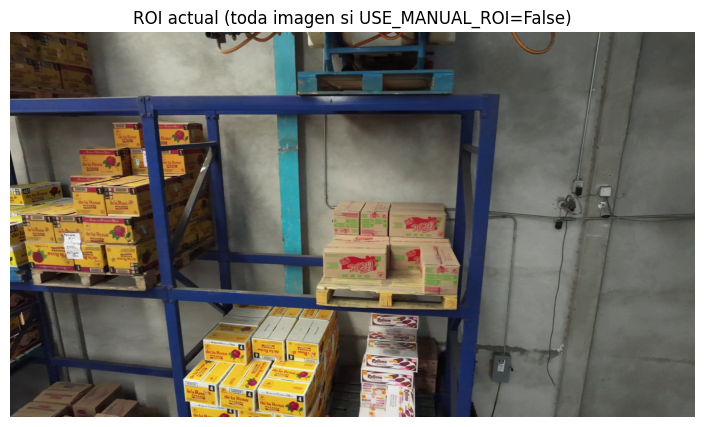

In [76]:
# =========================
# (CELDA C) Cargar primer frame + mostrar ROI
# =========================
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

CSV_PATH = "/content/drive/MyDrive/Proyecto Integrador Equipo37/Video Segmentation/data/fe/frames_features_selected.csv"
FRAMES_DIR = "/content/drive/MyDrive/Proyecto Integrador Equipo37/Video Segmentation/data/Processed Images"

df_sel = pd.read_csv(CSV_PATH)
selected_filenames = df_sel["filename"].tolist()

first_path = os.path.join(FRAMES_DIR, selected_filenames[0])
img = Image.open(first_path).convert("RGB")

print("Frame:", selected_filenames[0], "| size:", img.size)
print("USE_MANUAL_ROI:", USE_MANUAL_ROI, "| MANUAL_ROI:", MANUAL_ROI)

roi_pil, _ = crop_roi(img, get_pallet_roi_bbox(img))

plt.figure(figsize=(10,5))
plt.imshow(roi_pil)
plt.axis("off")
plt.title("ROI actual (toda imagen si USE_MANUAL_ROI=False)")
plt.show()

In [77]:
# =========================
# (CELDA D) DINOv2 + KMeans + filtro fuerte + NMS
# =========================
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def dinov2_cluster_count(frame_pil,
                         window_sizes=(160,192),
                         strides=(96,112),
                         pca_dim=50,
                         k=2,
                         iou_thr=0.60,
                         batch_size=32,
                         cluster_top_percentile=90):   # <- MÁS ESTRICTO (top 10%)

    roi_bbox = get_pallet_roi_bbox(frame_pil)
    roi_pil, _ = crop_roi(frame_pil, roi_bbox)
    w, h = roi_pil.size

    boxes = generate_grid_boxes(w, h, window_sizes, strides)
    crops = crop_boxes_from_roi(roi_pil, boxes)
    print("ROI size:", (w,h), "| Num windows:", len(boxes))

    # embeddings
    X = dino_embed_batch(crops, batch_size=batch_size)

    # PCA + KMeans
    pca_dim_eff = min(pca_dim, X.shape[0], X.shape[1])
    Xp = PCA(n_components=pca_dim_eff, random_state=0).fit_transform(X)

    km = KMeans(n_clusters=k, n_init=10, random_state=0)
    labels = km.fit_predict(Xp)

    # elegir cluster con mayor "boxiness" promedio (más selectivo)
    boxiness = np.array([boxiness_score(c) for c in crops], dtype=np.float32)

    cluster_means = []
    for cid in range(k):
        m = float(boxiness[labels == cid].mean()) if np.any(labels == cid) else 0.0
        cluster_means.append(m)

    box_cluster = int(np.argmax(cluster_means))
    print("Boxiness mean por cluster:", cluster_means)
    print("Cluster elegido como 'cajas':", box_cluster)

    idx_cluster = np.where(labels == box_cluster)[0]
    boxes_c = boxes[idx_cluster]
    scores_c = boxiness[idx_cluster]

    # filtro MÁS fuerte dentro del cluster (top 10%)
    score_thr = float(np.percentile(scores_c, cluster_top_percentile))
    count, keep_idx_local = nms_count(boxes_c, scores_c, iou_thr=iou_thr, score_thr=score_thr)
    keep_idx_global = idx_cluster[keep_idx_local]

    return {
        "roi_pil": roi_pil,
        "boxes": boxes,
        "labels": labels,
        "scores": boxiness,
        "box_cluster": box_cluster,
        "keep_idx_global": keep_idx_global,
        "count": count,
        "score_thr": score_thr,
        "cluster_means": cluster_means
    }

res = dinov2_cluster_count(img)
print("DINOv2 (clustering) count:", res["count"])

ROI size: (1920, 1080) | Num windows: 318
Boxiness mean por cluster: [0.052520763128995895, 0.010890183039009571]
Cluster elegido como 'cajas': 0
DINOv2 (clustering) count: 13


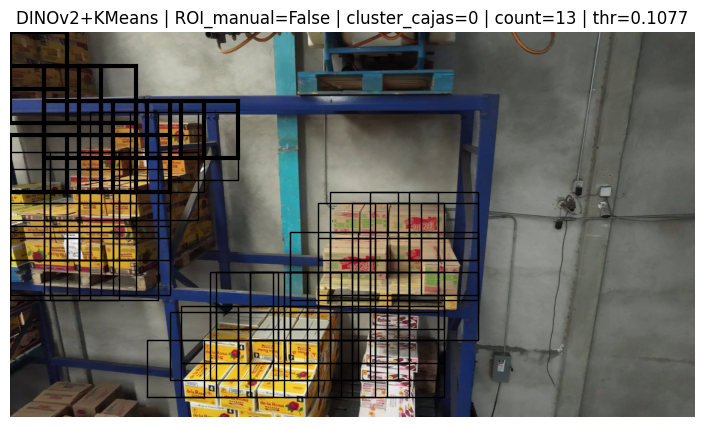

In [78]:
# =========================
# (CELDA E) Visualización
# =========================
import matplotlib.pyplot as plt
import numpy as np

def plot_cluster_and_final(res, max_cluster_draw=80):
    roi_pil = res["roi_pil"]
    boxes = res["boxes"]
    labels = res["labels"]
    scores = res["scores"]
    box_cluster = res["box_cluster"]
    keep_idx = res["keep_idx_global"]
    score_thr = res["score_thr"]

    fig, ax = plt.subplots(figsize=(10,5))
    ax.imshow(roi_pil)
    ax.axis("off")
    ax.set_title(f"DINOv2+KMeans | ROI_manual={USE_MANUAL_ROI} | cluster_cajas={box_cluster} | count={len(keep_idx)} | thr={score_thr:.4f}")

    # candidatos del cluster (muestra pequeña)
    idx_cluster = np.where(labels == box_cluster)[0]
    if len(idx_cluster) > max_cluster_draw:
        # muestra los mejores por score, no aleatorio
        best = idx_cluster[np.argsort(-scores[idx_cluster])[:max_cluster_draw]]
        idx_cluster = best

    for i in idx_cluster:
        x1,y1,x2,y2 = boxes[i]
        ax.add_patch(plt.Rectangle((x1,y1), x2-x1, y2-y1, fill=False, linewidth=1))

    # finales tras NMS (grueso)
    for i in keep_idx:
        x1,y1,x2,y2 = boxes[i]
        ax.add_patch(plt.Rectangle((x1,y1), x2-x1, y2-y1, fill=False, linewidth=3))

    plt.show()

plot_cluster_and_final(res)

**Aplicación de Dinov2 (ROI - Region of Interest: 1 Palet)**

In [79]:
# ====== A) ROI MANUAL (1 pallet) ======
USE_MANUAL_ROI = True
MANUAL_ROI = (820, 360, 1450, 850)  # (x1,y1,x2,y2) AJUSTA si hace falta

def get_pallet_roi_bbox(frame_pil, meta=None):
    if meta and "pallet_bbox" in meta and meta["pallet_bbox"] is not None:
        return tuple(meta["pallet_bbox"])
    w, h = frame_pil.size
    return MANUAL_ROI if USE_MANUAL_ROI else (0, 0, w, h)

In [80]:
# ====== D) RUN (DINOv2 + KMeans) sobre ROI manual ======
res = dinov2_cluster_count(
    img,
    window_sizes=(160,192),
    strides=(96,112),
    iou_thr=0.70,
    cluster_top_percentile=93
)

print("ROI_manual:", USE_MANUAL_ROI, "| MANUAL_ROI:", MANUAL_ROI)
print("DINOv2 (clustering) count:", res["count"])

ROI size: (630, 490) | Num windows: 32
Boxiness mean por cluster: [0.04402366653084755, 0.03729591891169548]
Cluster elegido como 'cajas': 0
ROI_manual: True | MANUAL_ROI: (820, 360, 1450, 850)
DINOv2 (clustering) count: 1


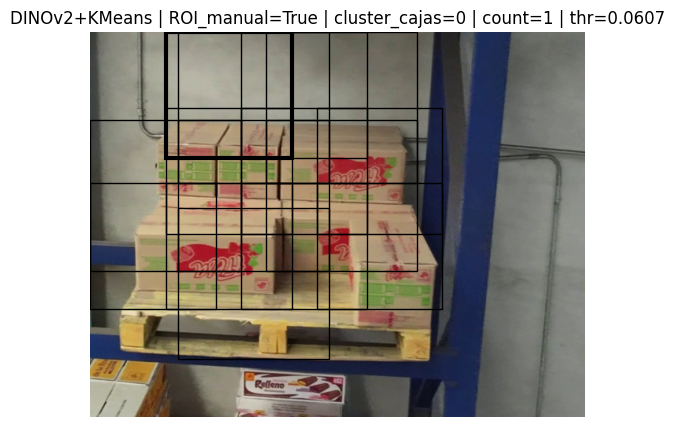

In [81]:
# ====== E) VISUAL ======
plot_cluster_and_final(res)

**Conclusiones Dinov2**

En esta etapa se implementó un baseline de conteo de cajas utilizando DINOv2 como extractor de características visuales, evitando cualquier entrenamiento adicional (“no time to train”). El modelo preentrenado se empleó para transformar cada ventana (sliding window) del frame en un embedding de alta dimensionalidad, y posteriormente se aplicó K-Means (K=2) para agrupar automáticamente las regiones del ROI según similitud visual.

Los resultados muestran que el enfoque no supervisado es capaz de separar regiones con patrones visuales similares a cajas frente a regiones de fondo (pared, estructura, cables), especialmente cuando se utiliza un ROI manual centrado en un pallet, lo cual reduce significativamente el ruido del entorno y mejora la interpretabilidad de la visualización.

Sin embargo, se observó que el conteo obtenido representa principalmente regiones con alta probabilidad de contener cajas, y no necesariamente instancias individuales. Esto se debe a que DINOv2 no es un detector nativo de objetos, por lo que el método depende del esquema de ventanas deslizantes, del filtrado posterior y del Non-Maximum Suppression (NMS) para evitar duplicados. En consecuencia, el número final puede reflejar “zonas” de cajas más que cajas unitarias cuando existen múltiples ventanas solapadas sobre un mismo objeto.

Finalmente, este método se considera un baseline sólido para comparación, ya que utiliza únicamente información visual y clustering, sin prompts ni supervisión explícita. Su principal ventaja es la simplicidad y rapidez de implementación, mientras que su limitación es la falta de segmentación por instancia, por lo que se espera que enfoques basados en segmentación (como SAM) produzcan conteos más cercanos a la realidad cuando el objetivo sea contabilizar cajas individuales.